In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

import json
from datetime import datetime
import argparse
from scipy import ndimage
import torch
import torchvision
import os
import torchvision.transforms as transforms
from collections import defaultdict, OrderedDict
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import time
import random
import yaml
import logging
import shutil
from models.resnet import NormalizeLayer, Mixed
from models.simple import reseed
from utils.utils import *
from utils.image_helper import ImageHelper
from utils.text_helper import TextHelper
logger = logging.getLogger('logger')
from prompt_toolkit import prompt
from training import *
from utils.utils import *
from IPython.display import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

pilimage = ToPILImage()
import hiddenlayer as hl

from tqdm import tqdm_notebook as tqdm
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from models.smoothnet import sresnet

In [5]:
no_back = {'backward': [0.11332941055297852, 0.12278413772583008, 0.11820459365844727, 0.11861681938171387, 0.12035393714904785, 0.1188054084777832, 0.11790728569030762, 0.11743927001953125, 0.12064218521118164, 0.11808395385742188, 0.11912369728088379, 0.1169133186340332, 0.11897850036621094, 0.11821651458740234, 0.11890864372253418, 0.11875176429748535, 0.11960792541503906, 0.1175074577331543, 0.12035751342773438, 0.11797904968261719, 0.12097811698913574, 0.11889004707336426, 0.11543512344360352, 0.12238526344299316, 0.11809468269348145, 0.11906313896179199, 0.11840963363647461, 0.11814045906066895, 0.11839175224304199, 0.11743974685668945, 0.1176445484161377, 0.11831092834472656, 0.11939048767089844, 0.11474847793579102, 0.12142825126647949, 0.11804628372192383, 0.1203000545501709, 0.11829853057861328, 0.11862921714782715, 0.11845827102661133, 0.11859464645385742, 0.12068414688110352, 0.11954498291015625, 0.11830520629882812, 0.11455535888671875, 0.11977720260620117, 0.11957573890686035, 0.12038922309875488, 0.11928915977478027, 0.11898350715637207, 0.1201934814453125, 0.11980891227722168, 0.1186676025390625, 0.11891818046569824, 0.12110662460327148, 0.11489725112915039, 0.12010908126831055, 0.1209115982055664, 0.11836528778076172, 0.11800408363342285, 0.12082600593566895, 0.1205739974975586, 0.11893177032470703, 0.12178874015808105, 0.11956477165222168, 0.12002444267272949, 0.11733508110046387, 0.11902570724487305, 0.12023520469665527, 0.12136483192443848, 0.11943626403808594, 0.12008070945739746, 0.12080645561218262, 0.12142205238342285, 0.12003278732299805, 0.12021040916442871, 0.12130117416381836, 0.11662435531616211, 0.1190798282623291, 0.1193540096282959, 0.12113380432128906, 0.12097692489624023, 0.12042379379272461, 0.12022018432617188, 0.12079095840454102, 0.11731719970703125, 0.12224507331848145, 0.11950826644897461, 0.1157834529876709, 0.12073993682861328, 0.11964964866638184, 0.11809468269348145, 0.12197518348693848, 0.12140488624572754, 0.11819577217102051, 0.1186678409576416, 0.11882591247558594, 0.11802124977111816, 0.11974334716796875, 0.11400747299194336, 0.12203407287597656, 0.1212623119354248, 0.11897540092468262, 0.12021780014038086, 0.11898255348205566, 0.12030482292175293, 0.12068295478820801, 0.11958456039428711, 0.11974740028381348, 0.1179192066192627], 'forward': [0.04304242134094238, 0.009198188781738281, 0.009111642837524414, 0.009082794189453125, 0.009117603302001953, 0.009090900421142578, 0.00911092758178711, 0.009134054183959961, 0.009094476699829102, 0.00914907455444336, 0.009479284286499023, 0.013143062591552734, 0.009655237197875977, 0.010273456573486328, 0.010104894638061523, 0.009492158889770508, 0.009098529815673828, 0.009540081024169922, 0.009088993072509766, 0.0090789794921875, 0.009132146835327148, 0.009109973907470703, 0.013164043426513672, 0.009290218353271484, 0.009185791015625, 0.009093046188354492, 0.009194374084472656, 0.009116649627685547, 0.009153604507446289, 0.009121894836425781, 0.009124755859375, 0.009111166000366211, 0.009113311767578125, 0.013172149658203125, 0.009239673614501953, 0.009137868881225586, 0.009145975112915039, 0.009139776229858398, 0.009094476699829102, 0.009122133255004883, 0.009128093719482422, 0.009080171585083008, 0.009070396423339844, 0.009107112884521484, 0.013717412948608398, 0.009259700775146484, 0.00910806655883789, 0.009101152420043945, 0.009104013442993164, 0.00906682014465332, 0.009092092514038086, 0.009127140045166016, 0.009111166000366211, 0.009147882461547852, 0.00943613052368164, 0.01316690444946289, 0.009244680404663086, 0.009181737899780273, 0.009161949157714844, 0.009120702743530273, 0.009126663208007812, 0.009117364883422852, 0.00913381576538086, 0.009090185165405273, 0.009172201156616211, 0.009139776229858398, 0.013137340545654297, 0.009219884872436523, 0.009114503860473633, 0.009108781814575195, 0.009122610092163086, 0.0090789794921875, 0.009102344512939453, 0.009094476699829102, 0.009059667587280273, 0.009065389633178711, 0.009145975112915039, 0.013214826583862305, 0.009308815002441406, 0.009104490280151367, 0.00902247428894043, 0.009147882461547852, 0.00911569595336914, 0.009192705154418945, 0.009460210800170898, 0.010118722915649414, 0.009056329727172852, 0.009051322937011719, 0.013278484344482422, 0.009209156036376953, 0.009164810180664062, 0.009171485900878906, 0.009107828140258789, 0.009144067764282227, 0.00922703742980957, 0.009152412414550781, 0.009132623672485352, 0.010161161422729492, 0.009784221649169922, 0.013185739517211914, 0.00974726676940918, 0.009134769439697266, 0.009142160415649414, 0.009154081344604492, 0.00912022590637207, 0.009100675582885742, 0.00912332534790039, 0.009089231491088867, 0.009123802185058594, 0.009575128555297852], 'step': [0.01724720001220703, 0.01138162612915039, 0.011483430862426758, 0.01198434829711914, 0.013912439346313477, 0.012532711029052734, 0.011784076690673828, 0.015921831130981445, 0.016065597534179688, 0.013164281845092773, 0.01362299919128418, 0.018984317779541016, 0.011931896209716797, 0.01222538948059082, 0.012192726135253906, 0.011615276336669922, 0.01308584213256836, 0.011169672012329102, 0.012042760848999023, 0.011002540588378906, 0.011686563491821289, 0.012967586517333984, 0.01767706871032715, 0.017591238021850586, 0.01210641860961914, 0.014707565307617188, 0.014813423156738281, 0.01656174659729004, 0.015649795532226562, 0.013179779052734375, 0.008826255798339844, 0.011703252792358398, 0.016047954559326172, 0.013069868087768555, 0.016245126724243164, 0.011127710342407227, 0.013134479522705078, 0.016193866729736328, 0.012025833129882812, 0.011654376983642578, 0.013067483901977539, 0.012617111206054688, 0.016108036041259766, 0.012090444564819336, 0.0184323787689209, 0.01492929458618164, 0.011664390563964844, 0.01207733154296875, 0.012060403823852539, 0.01455998420715332, 0.012146711349487305, 0.014116048812866211, 0.0104827880859375, 0.01627802848815918, 0.008680343627929688, 0.010619401931762695, 0.010339975357055664, 0.012605667114257812, 0.010544300079345703, 0.011531591415405273, 0.013649940490722656, 0.016895771026611328, 0.014261484146118164, 0.011516094207763672, 0.016593456268310547, 0.01868581771850586, 0.01458287239074707, 0.012121200561523438, 0.014148950576782227, 0.013763904571533203, 0.012969732284545898, 0.011605501174926758, 0.01507878303527832, 0.016115188598632812, 0.015505313873291016, 0.015486955642700195, 0.011846780776977539, 0.014323949813842773, 0.014600753784179688, 0.011974811553955078, 0.013371706008911133, 0.008708477020263672, 0.013239622116088867, 0.011566400527954102, 0.013033151626586914, 0.014514684677124023, 0.013804197311401367, 0.013595104217529297, 0.013900279998779297, 0.015199661254882812, 0.00917363166809082, 0.011234283447265625, 0.015023231506347656, 0.010053157806396484, 0.01905345916748047, 0.01953864097595215, 0.01715397834777832, 0.014956235885620117, 0.011785030364990234, 0.013708114624023438, 0.010895013809204102, 0.016933917999267578, 0.016535043716430664, 0.016352415084838867, 0.016957521438598633, 0.019501209259033203, 0.011968374252319336, 0.009154081344604492, 0.01509237289428711, 0.009735822677612305], 'scales': [], 'total': [0.178541898727417, 0.14801406860351562, 0.14359664916992188, 0.14437603950500488, 0.14803576469421387, 0.14523720741271973, 0.14345860481262207, 0.14730286598205566, 0.15059328079223633, 0.1450510025024414, 0.14705300331115723, 0.15361380577087402, 0.1453230381011963, 0.14588618278503418, 0.14635920524597168, 0.1448068618774414, 0.14645075798034668, 0.1430041790008545, 0.1461493968963623, 0.14272189140319824, 0.14646553993225098, 0.14565110206604004, 0.15105223655700684, 0.15409231185913086, 0.14406228065490723, 0.14752817153930664, 0.14707350730895996, 0.14848566055297852, 0.14786934852600098, 0.144575834274292, 0.14066672325134277, 0.14377450942993164, 0.1492311954498291, 0.14556360244750977, 0.15170860290527344, 0.14310741424560547, 0.14725446701049805, 0.14827895164489746, 0.14441943168640137, 0.14389657974243164, 0.14548635482788086, 0.14703893661499023, 0.1495661735534668, 0.14416146278381348, 0.15134501457214355, 0.14863872528076172, 0.14502215385437012, 0.14622783660888672, 0.1451096534729004, 0.14732146263122559, 0.1461184024810791, 0.14771342277526855, 0.14290308952331543, 0.1491081714630127, 0.1440567970275879, 0.14324259757995605, 0.14439034461975098, 0.14734721183776855, 0.14273834228515625, 0.14328598976135254, 0.14827919006347656, 0.15123534202575684, 0.14703035354614258, 0.14707279205322266, 0.15005707740783691, 0.15252113342285156, 0.14960956573486328, 0.14500856399536133, 0.14815354347229004, 0.14899992942810059, 0.14635586738586426, 0.14557242393493652, 0.149672269821167, 0.15129613876342773, 0.1492595672607422, 0.14949917793273926, 0.14701104164123535, 0.14884710311889648, 0.14775586128234863, 0.14511442184448242, 0.1481635570526123, 0.1436171531677246, 0.14760375022888184, 0.14565467834472656, 0.1481008529663086, 0.14682316780090332, 0.14983820915222168, 0.14670300483703613, 0.14759397506713867, 0.14981842041015625, 0.14280462265014648, 0.1432020664215088, 0.1507563591003418, 0.14524126052856445, 0.1513972282409668, 0.1520702838897705, 0.14981937408447266, 0.14810633659362793, 0.14621591567993164, 0.14557576179504395, 0.1473383903503418, 0.15195631980895996, 0.14937210083007812, 0.15046072006225586, 0.14980649948120117, 0.1536235809326172, 0.1464686393737793, 0.1424884796142578, 0.14879918098449707, 0.1420450210571289]}

In [7]:
eq_back = {'backward': [0.2531607151031494, 0.24578285217285156, 0.22845792770385742, 0.22995591163635254, 0.22852230072021484, 0.23056983947753906, 0.2324223518371582, 0.23155689239501953, 0.2320709228515625, 0.23081612586975098, 0.2329118251800537, 0.22622084617614746, 0.2308659553527832, 0.23068928718566895, 0.22979187965393066, 0.22832989692687988, 0.23223519325256348, 0.2324538230895996, 0.23011374473571777, 0.23050498962402344, 0.2335193157196045, 0.23051095008850098, 0.22817516326904297, 0.23395466804504395, 0.23642492294311523, 0.23225021362304688, 0.23243927955627441, 0.23160958290100098, 0.23473548889160156, 0.23259663581848145, 0.23165392875671387, 0.23201203346252441, 0.22937822341918945, 0.22846722602844238, 0.23051857948303223, 0.23354697227478027, 0.23286938667297363, 0.23294377326965332, 0.233154296875, 0.2345719337463379, 0.23208975791931152, 0.23174548149108887, 0.23248004913330078, 0.23368191719055176, 0.22755980491638184, 0.23293161392211914, 0.23302197456359863, 0.23303794860839844, 0.23237872123718262, 0.2333221435546875, 0.23357248306274414, 0.23308753967285156, 0.23286843299865723, 0.23336005210876465, 0.23395752906799316, 0.23073101043701172, 0.23092937469482422, 0.23184752464294434, 0.2329118251800537, 0.2319660186767578, 0.2327556610107422, 0.233748197555542, 0.23418378829956055, 0.2352311611175537, 0.2351970672607422, 0.23459458351135254, 0.22907614707946777, 0.23323750495910645, 0.2348477840423584, 0.23338818550109863, 0.2339324951171875, 0.23534536361694336, 0.23338985443115234, 0.23587846755981445, 0.23449969291687012, 0.23359274864196777, 0.2361924648284912, 0.2305164337158203, 0.23200726509094238, 0.23419594764709473, 0.23377108573913574, 0.23601126670837402, 0.23482227325439453, 0.23361682891845703, 0.23422956466674805, 0.23560428619384766, 0.23514699935913086, 0.23457002639770508, 0.22916841506958008, 0.233428955078125, 0.2322556972503662, 0.23581933975219727, 0.23601245880126953, 0.2360224723815918, 0.23309922218322754, 0.23523640632629395, 0.23595786094665527, 0.2373030185699463, 0.2361130714416504, 0.23035979270935059, 0.2343282699584961, 0.2352297306060791, 0.2362661361694336, 0.2341630458831787, 0.23348379135131836, 0.23682284355163574, 0.23454570770263672, 0.2345287799835205, 0.23590612411499023, 0.23395180702209473], 'forward': [0.04128241539001465, 0.016568660736083984, 0.008968830108642578, 0.008639097213745117, 0.009824275970458984, 0.010069608688354492, 0.008820772171020508, 0.008559465408325195, 0.009494304656982422, 0.009219884872436523, 0.008879899978637695, 0.00863504409790039, 0.008903980255126953, 0.008475303649902344, 0.008756637573242188, 0.008419275283813477, 0.009155988693237305, 0.008882999420166016, 0.008787870407104492, 0.008439064025878906, 0.00913095474243164, 0.009346485137939453, 0.013390064239501953, 0.008900880813598633, 0.008901357650756836, 0.008633136749267578, 0.008705377578735352, 0.008736371994018555, 0.008727312088012695, 0.008377790451049805, 0.00899815559387207, 0.012977361679077148, 0.009513139724731445, 0.009669303894042969, 0.008778095245361328, 0.008394956588745117, 0.008774518966674805, 0.009654760360717773, 0.00877833366394043, 0.008466958999633789, 0.00873875617980957, 0.008501291275024414, 0.0098724365234375, 0.009145259857177734, 0.01347494125366211, 0.008558988571166992, 0.008866071701049805, 0.008523941040039062, 0.008769989013671875, 0.008472681045532227, 0.008758306503295898, 0.00844430923461914, 0.008774995803833008, 0.008617401123046875, 0.008858203887939453, 0.008522748947143555, 0.00886392593383789, 0.008645772933959961, 0.008826494216918945, 0.008482217788696289, 0.009179115295410156, 0.008842706680297852, 0.008740425109863281, 0.008426189422607422, 0.008800506591796875, 0.008435249328613281, 0.013806581497192383, 0.008492469787597656, 0.00897526741027832, 0.008528709411621094, 0.00874948501586914, 0.008466720581054688, 0.00874781608581543, 0.008418560028076172, 0.008803844451904297, 0.008426666259765625, 0.00873708724975586, 0.008368253707885742, 0.008754253387451172, 0.008416891098022461, 0.008733272552490234, 0.008403301239013672, 0.008757829666137695, 0.008425474166870117, 0.008788347244262695, 0.008444547653198242, 0.008768081665039062, 0.008406639099121094, 0.013517618179321289, 0.008521080017089844, 0.008893013000488281, 0.008585691452026367, 0.008789539337158203, 0.008469104766845703, 0.008703947067260742, 0.008396148681640625, 0.008786916732788086, 0.008921384811401367, 0.008745431900024414, 0.008418560028076172, 0.00875711441040039, 0.008400201797485352, 0.008791208267211914, 0.008420467376708984, 0.008758544921875, 0.008435487747192383, 0.008806467056274414, 0.008419275283813477, 0.008799076080322266, 0.008420705795288086, 0.013516902923583984, 0.00856161117553711, 0.00892782211303711, 0.008563756942749023, 0.008786916732788086, 0.008495569229125977, 0.008737564086914062, 0.008402585983276367, 0.008754730224609375, 0.008409500122070312, 0.008734941482543945, 0.008388757705688477, 0.008778810501098633, 0.008422136306762695, 0.008809804916381836, 0.008436441421508789, 0.008769750595092773, 0.008442878723144531, 0.008797645568847656, 0.00845646858215332, 0.0087890625, 0.008441686630249023, 0.01341700553894043, 0.008592844009399414, 0.008913755416870117, 0.008593559265136719, 0.008760690689086914, 0.008522748947143555, 0.008813619613647461, 0.008479833602905273, 0.008750677108764648, 0.008474349975585938, 0.00876164436340332, 0.00843954086303711, 0.00876617431640625, 0.008944988250732422, 0.008736610412597656, 0.00841069221496582, 0.008749961853027344, 0.008428335189819336, 0.008744478225708008, 0.008412361145019531, 0.00901937484741211, 0.009371757507324219, 0.013475418090820312, 0.008563756942749023, 0.008923530578613281, 0.009137392044067383, 0.00882863998413086, 0.008546113967895508, 0.008824348449707031, 0.008405685424804688, 0.008783102035522461, 0.008459091186523438, 0.009253501892089844, 0.008886575698852539, 0.008915185928344727, 0.0085296630859375, 0.00881648063659668, 0.008445024490356445, 0.008822441101074219, 0.008488178253173828, 0.009123563766479492, 0.008786916732788086, 0.008788824081420898, 0.00845193862915039, 0.013478517532348633, 0.008563041687011719, 0.009007930755615234, 0.00869131088256836, 0.008819103240966797, 0.008546113967895508, 0.008830785751342773, 0.008410930633544922, 0.008788585662841797, 0.008753299713134766, 0.008738517761230469, 0.008425235748291016, 0.009223461151123047, 0.008889198303222656, 0.008807897567749023, 0.008466005325317383, 0.008820533752441406, 0.008461475372314453, 0.008815288543701172, 0.008488178253173828, 0.008812189102172852, 0.008447647094726562, 0.013466358184814453, 0.008545398712158203, 0.008982658386230469, 0.008594274520874023, 0.008761167526245117, 0.008483409881591797, 0.008738517761230469, 0.008388757705688477, 0.008881568908691406, 0.008466243743896484, 0.008798360824584961, 0.008444786071777344, 0.008891105651855469, 0.008469343185424805, 0.008846759796142578, 0.008479595184326172, 0.008815765380859375, 0.008462667465209961, 0.008749723434448242, 0.008561849594116211, 0.008806228637695312, 0.00868844985961914], 'step': [0.018180131912231445, 0.010907173156738281, 0.01259469985961914, 0.015125513076782227, 0.016396760940551758, 0.015646934509277344, 0.015224218368530273, 0.01292276382446289, 0.014180421829223633, 0.01292872428894043, 0.011442899703979492, 0.016451120376586914, 0.013966798782348633, 0.009389877319335938, 0.01747441291809082, 0.01037144660949707, 0.012372732162475586, 0.012192010879516602, 0.0118408203125, 0.016855716705322266, 0.010131597518920898, 0.012517213821411133, 0.014061689376831055, 0.014457225799560547, 0.015899181365966797, 0.010900020599365234, 0.013175010681152344, 0.017478227615356445, 0.013588190078735352, 0.014365434646606445, 0.014155149459838867, 0.018647193908691406, 0.014729738235473633, 0.014002323150634766, 0.018265485763549805, 0.01738452911376953, 0.014911651611328125, 0.01587533950805664, 0.015702247619628906, 0.014726400375366211, 0.015918731689453125, 0.01645207405090332, 0.01520681381225586, 0.014915704727172852, 0.017385244369506836, 0.014822006225585938, 0.015941381454467773, 0.017985820770263672, 0.012631893157958984, 0.018537521362304688, 0.015134334564208984, 0.016912221908569336, 0.01722407341003418, 0.017151594161987305, 0.017214298248291016, 0.01724720001220703, 0.01784491539001465, 0.01653146743774414, 0.01781153678894043, 0.017021656036376953, 0.016521692276000977, 0.014472484588623047, 0.018574237823486328, 0.009952068328857422, 0.014149665832519531, 0.01892232894897461, 0.01585841178894043, 0.01368570327758789, 0.008134841918945312, 0.016846656799316406, 0.0141448974609375, 0.012479305267333984, 0.01801753044128418, 0.013459205627441406, 0.008430719375610352, 0.018903017044067383, 0.013788461685180664, 0.017985105514526367, 0.014909505844116211, 0.012896537780761719, 0.0175778865814209, 0.01707625389099121, 0.011556625366210938, 0.010976791381835938, 0.015755891799926758, 0.013580560684204102, 0.013695240020751953, 0.011631011962890625, 0.01855325698852539, 0.015396595001220703, 0.018398046493530273, 0.016201019287109375, 0.011726140975952148, 0.012375116348266602, 0.010880708694458008, 0.00954580307006836, 0.014047861099243164, 0.01102304458618164, 0.011266231536865234, 0.017453432083129883, 0.01652836799621582, 0.013420343399047852, 0.013724327087402344, 0.016558408737182617, 0.016767501831054688, 0.013955831527709961, 0.016500473022460938, 0.016015052795410156, 0.017693519592285156, 0.011913299560546875], 'scales': [], 'total': [0.335590124130249, 0.28005313873291016, 0.26691269874572754, 0.26823854446411133, 0.26949405670166016, 0.26953721046447754, 0.27088332176208496, 0.267467737197876, 0.2702305316925049, 0.2667391300201416, 0.26909923553466797, 0.2707231044769287, 0.26845836639404297, 0.2636911869049072, 0.2700788974761963, 0.2674577236175537, 0.269611120223999, 0.26756930351257324, 0.26645541191101074, 0.27060985565185547, 0.2666044235229492, 0.2685418128967285, 0.26983141899108887, 0.27152013778686523, 0.275343656539917, 0.2662196159362793, 0.2688415050506592, 0.272388219833374, 0.27181506156921387, 0.27006030082702637, 0.26961350440979004, 0.27360105514526367, 0.26706790924072266, 0.2702796459197998, 0.2719695568084717, 0.2739145755767822, 0.2707235813140869, 0.2717933654785156, 0.27171802520751953, 0.2721531391143799, 0.2709167003631592, 0.27113771438598633, 0.27071642875671387, 0.2715318202972412, 0.27252840995788574, 0.2709510326385498, 0.2719733715057373, 0.27391862869262695, 0.2684364318847656, 0.2748732566833496, 0.27158379554748535, 0.27303099632263184, 0.27304840087890625, 0.27348995208740234, 0.27414989471435547, 0.2755923271179199, 0.2720654010772705, 0.2714076042175293, 0.27358150482177734, 0.27187538146972656, 0.27216672897338867, 0.27111101150512695, 0.2757754325866699, 0.26809048652648926, 0.27239346504211426, 0.27649521827697754, 0.27244091033935547, 0.27023959159851074, 0.26598691940307617, 0.273329496383667, 0.2710540294647217, 0.27083849906921387, 0.2748689651489258, 0.27222561836242676, 0.2658348083496094, 0.2754337787628174, 0.2745552062988281, 0.2760190963745117, 0.2707788944244385, 0.27017664909362793, 0.27435755729675293, 0.27599287033081055, 0.27034735679626465, 0.2677593231201172, 0.2729763984680176, 0.27222371101379395, 0.272585391998291, 0.26912665367126465, 0.27524662017822266, 0.272294282913208, 0.27371668815612793, 0.2749929428100586, 0.27112245559692383, 0.271242618560791, 0.2679479122161865, 0.26773929595947266, 0.2729923725128174, 0.27130770683288574, 0.2703890800476074, 0.27538061141967773, 0.27411389350891113, 0.2716681957244873, 0.2728579044342041, 0.27378153800964355, 0.27327466011047363, 0.27385902404785156, 0.274106502532959, 0.27361440658569336, 0.27691125869750977, 0.2693202495574951]}

In [37]:
my_back = {'backward': [0.11980080604553223, 0.11146092414855957, 0.18368220329284668, 0.11443853378295898, 0.11128830909729004, 0.18123841285705566, 0.11496949195861816, 0.11074399948120117, 0.1815650463104248, 0.11404585838317871, 0.11238598823547363, 0.18122124671936035, 0.11547183990478516, 0.11070537567138672, 0.1812453269958496, 0.11577939987182617, 0.10728693008422852, 0.18272614479064941, 0.11259698867797852, 0.10902285575866699, 0.18305087089538574, 0.11425399780273438, 0.11131024360656738, 0.18240618705749512, 0.11626887321472168, 0.11116361618041992, 0.18220996856689453, 0.11500215530395508, 0.11089873313903809, 0.18214893341064453, 0.1153097152709961, 0.11183428764343262, 0.18457460403442383, 0.1111137866973877, 0.1113133430480957, 0.18224430084228516, 0.11522483825683594, 0.1112203598022461, 0.1816706657409668, 0.1153113842010498, 0.11148357391357422, 0.18291378021240234, 0.11342716217041016, 0.10372257232666016, 0.1836860179901123, 0.11464643478393555, 0.10412907600402832, 0.1824028491973877, 0.11406636238098145, 0.11349630355834961, 0.18389105796813965, 0.11482930183410645, 0.1121370792388916, 0.18257474899291992, 0.11530089378356934, 0.11330175399780273, 0.1834886074066162, 0.11506223678588867, 0.1119222640991211, 0.18453311920166016, 0.1139841079711914, 0.10933685302734375, 0.18336868286132812, 0.11411213874816895, 0.10903429985046387, 0.1823415756225586, 0.1106863021850586, 0.10628986358642578, 0.1825556755065918, 0.1146848201751709, 0.10981011390686035, 0.1831042766571045, 0.11487793922424316, 0.11119747161865234, 0.1834871768951416, 0.1162874698638916, 0.11164379119873047, 0.18291902542114258, 0.11440539360046387, 0.1105048656463623, 0.182755708694458, 0.11502528190612793, 0.1104269027709961, 0.1831822395324707, 0.11639523506164551, 0.1114501953125, 0.18327760696411133, 0.11636543273925781, 0.11196780204772949, 0.18312358856201172, 0.11577963829040527, 0.11151599884033203, 0.18373560905456543, 0.11463618278503418, 0.10957551002502441, 0.18452835083007812, 0.11532878875732422, 0.10966062545776367, 0.18327593803405762, 0.10919785499572754, 0.10584568977355957, 0.1850261688232422, 0.115570068359375, 0.11336040496826172, 0.1840217113494873, 0.11595034599304199, 0.11026453971862793, 0.18347716331481934, 0.11543965339660645, 0.10928702354431152, 0.1831357479095459, 0.11647295951843262, 0.1127622127532959, 0.184678316116333, 0.11586928367614746, 0.1084890365600586, 0.18509793281555176, 0.11602067947387695, 0.10840940475463867, 0.1845717430114746, 0.11672544479370117, 0.11234855651855469, 0.18432831764221191, 0.11564159393310547, 0.11184215545654297, 0.18441200256347656, 0.11524796485900879, 0.11095309257507324, 0.1846938133239746, 0.11555337905883789, 0.11167097091674805, 0.1847078800201416, 0.11237859725952148, 0.11228060722351074, 0.184434175491333, 0.11577343940734863, 0.11254286766052246, 0.1833193302154541, 0.11703729629516602, 0.11279487609863281, 0.18516755104064941, 0.11530542373657227, 0.11247563362121582, 0.18413591384887695, 0.11659026145935059, 0.11246776580810547, 0.1857151985168457, 0.11394906044006348, 0.10881924629211426, 0.18405723571777344, 0.11811566352844238, 0.11207842826843262, 0.18760275840759277, 0.11619067192077637, 0.1089479923248291, 0.18387961387634277, 0.11667513847351074, 0.11224746704101562, 0.1856670379638672, 0.1161351203918457, 0.11043453216552734, 0.18559694290161133, 0.11660385131835938, 0.11255979537963867, 0.18542766571044922, 0.11123418807983398, 0.11205267906188965, 0.18523788452148438, 0.1174769401550293, 0.11240744590759277, 0.18479394912719727, 0.11627650260925293, 0.10911011695861816, 0.1844925880432129, 0.11619734764099121, 0.11134719848632812, 0.184462308883667, 0.11556529998779297, 0.11276865005493164, 0.18486571311950684, 0.11723518371582031, 0.11236143112182617, 0.18450236320495605, 0.11713027954101562, 0.1130368709564209, 0.1853623390197754, 0.116180419921875, 0.11253905296325684, 0.18428444862365723, 0.11662077903747559, 0.11052060127258301, 0.18459677696228027, 0.11934065818786621, 0.10794854164123535, 0.18546485900878906, 0.11478209495544434, 0.11425566673278809, 0.18442940711975098, 0.11155462265014648, 0.11472201347351074, 0.18401598930358887, 0.11637568473815918, 0.10945463180541992, 0.1851825714111328, 0.11620664596557617, 0.11381936073303223, 0.18439698219299316, 0.11692929267883301, 0.11251091957092285, 0.18435049057006836, 0.11796426773071289, 0.11296200752258301, 0.18376398086547852, 0.1169886589050293, 0.1144094467163086, 0.1854410171508789, 0.11620569229125977, 0.11286616325378418, 0.18492674827575684, 0.11524033546447754, 0.11014246940612793, 0.1855461597442627, 0.11616992950439453, 0.11364030838012695, 0.18594026565551758, 0.11515593528747559, 0.1098933219909668, 0.1843400001525879, 0.11691880226135254, 0.10937833786010742, 0.1843857765197754, 0.11261487007141113, 0.11263537406921387, 0.18816614151000977, 0.11646318435668945, 0.1138601303100586, 0.1870737075805664, 0.11632919311523438, 0.11410284042358398, 0.18411755561828613, 0.11554503440856934, 0.11465144157409668, 0.1854705810546875, 0.11690521240234375, 0.11388015747070312, 0.1856858730316162, 0.11733007431030273, 0.11570477485656738, 0.18596243858337402, 0.1169579029083252, 0.11455988883972168, 0.1849677562713623, 0.116943359375, 0.11422991752624512, 0.18618202209472656, 0.11772751808166504, 0.111480712890625, 0.18476223945617676, 0.1180570125579834, 0.11387109756469727, 0.18549084663391113, 0.11579537391662598, 0.1145470142364502, 0.18500113487243652, 0.11130118370056152, 0.11384057998657227, 0.18587446212768555, 0.11556839942932129, 0.1118772029876709, 0.18438005447387695, 0.11749100685119629, 0.11297273635864258, 0.18521809577941895, 0.11680150032043457, 0.11221003532409668, 0.18581938743591309, 0.11642575263977051, 0.11303448677062988, 0.18523859977722168, 0.1172492504119873, 0.11249661445617676, 0.18644475936889648, 0.11804986000061035, 0.10950183868408203, 0.18461871147155762, 0.11915731430053711, 0.11028814315795898, 0.18457531929016113, 0.11684870719909668, 0.11053037643432617, 0.18488812446594238, 0.11752486228942871, 0.11318087577819824, 0.18423008918762207, 0.11670374870300293, 0.11002707481384277, 0.18578529357910156, 0.11353135108947754, 0.11445236206054688, 0.18441510200500488, 0.11655783653259277, 0.11319327354431152, 0.1859729290008545, 0.11635875701904297, 0.1103055477142334, 0.18645238876342773, 0.11636662483215332, 0.11013221740722656, 0.18547463417053223, 0.11625790596008301, 0.11388659477233887, 0.18546271324157715, 0.11585783958435059, 0.11141848564147949, 0.18627309799194336, 0.11709022521972656, 0.11217164993286133, 0.18586158752441406, 0.11639928817749023, 0.11198830604553223, 0.1859891414642334, 0.11685895919799805, 0.1139066219329834, 0.18480873107910156, 0.11646604537963867, 0.11099100112915039, 0.18623661994934082, 0.1163625717163086, 0.11294984817504883, 0.18553376197814941], 'forward': [0.040345191955566406, 0.02632880210876465, 0.008969306945800781, 0.01204681396484375, 0.008822917938232422, 0.011902809143066406, 0.00878596305847168, 0.011376619338989258, 0.00881505012512207, 0.012628793716430664, 0.00882411003112793, 0.01691150665283203, 0.009228944778442383, 0.015184640884399414, 0.008780241012573242, 0.012594938278198242, 0.008787393569946289, 0.012603759765625, 0.008765935897827148, 0.013162612915039062, 0.008802175521850586, 0.012531042098999023, 0.013428688049316406, 0.013164520263671875, 0.008908510208129883, 0.012299299240112305, 0.008811712265014648, 0.01257181167602539, 0.009134769439697266, 0.02033519744873047, 0.008789777755737305, 0.019816875457763672, 0.00878453254699707, 0.011878728866577148, 0.008790254592895508, 0.01146554946899414, 0.008874654769897461, 0.011072158813476562, 0.00882577896118164, 0.011771917343139648, 0.008784055709838867, 0.015383243560791016, 0.009180068969726562, 0.015036344528198242, 0.013530254364013672, 0.018033981323242188, 0.008881330490112305, 0.01522064208984375, 0.008819341659545898, 0.012743711471557617, 0.008764982223510742, 0.013029336929321289, 0.008769750595092773, 0.013096094131469727, 0.008794546127319336, 0.014949560165405273, 0.008803844451904297, 0.014728546142578125, 0.008791208267211914, 0.012623310089111328, 0.008756875991821289, 0.012541532516479492, 0.008760213851928711, 0.015139102935791016, 0.008831977844238281, 0.014864683151245117, 0.013684988021850586, 0.01944446563720703, 0.008914470672607422, 0.012419939041137695, 0.00878453254699707, 0.015104293823242188, 0.008767366409301758, 0.01598525047302246, 0.00879812240600586, 0.012161970138549805, 0.00876927375793457, 0.016724109649658203, 0.00879216194152832, 0.01622915267944336, 0.008764505386352539, 0.01257634162902832, 0.008760452270507812, 0.01252603530883789, 0.008783817291259766, 0.013901233673095703, 0.008788585662841797, 0.013097286224365234, 0.013456344604492188, 0.013247013092041016, 0.009341001510620117, 0.012763023376464844, 0.008838176727294922, 0.012580633163452148, 0.008766412734985352, 0.0130615234375, 0.008829832077026367, 0.012614250183105469, 0.009199142456054688, 0.015887975692749023, 0.008827924728393555, 0.013186454772949219, 0.008831501007080078, 0.01648855209350586, 0.008785724639892578, 0.013123750686645508, 0.008767843246459961, 0.01474618911743164, 0.008761405944824219, 0.013241767883300781, 0.013541936874389648, 0.013291358947753906, 0.008983612060546875, 0.012735128402709961, 0.009238719940185547, 0.01586151123046875, 0.008738279342651367, 0.013916492462158203, 0.008767366409301758, 0.01381230354309082, 0.008773326873779297, 0.012600183486938477, 0.008780479431152344, 0.012473583221435547, 0.008817672729492188, 0.012600183486938477, 0.008812427520751953, 0.01589202880859375, 0.009056329727172852, 0.017975807189941406, 0.00886082649230957, 0.013654232025146484, 0.013608694076538086, 0.011293411254882812, 0.008947372436523438, 0.01565074920654297, 0.008783578872680664, 0.013770818710327148, 0.008753061294555664, 0.013042688369750977, 0.008764028549194336, 0.012697935104370117, 0.008771657943725586, 0.011512517929077148, 0.008779764175415039, 0.012607097625732422, 0.008840799331665039, 0.017684459686279297, 0.008765459060668945, 0.012740373611450195, 0.008757352828979492, 0.01657891273498535, 0.008784770965576172, 0.016172170639038086, 0.013527393341064453, 0.012545347213745117, 0.00890970230102539, 0.011769533157348633, 0.008788824081420898, 0.011657238006591797, 0.008777856826782227, 0.011262655258178711, 0.008824825286865234, 0.011952638626098633, 0.008780241012573242, 0.012566804885864258, 0.008777379989624023, 0.012230157852172852, 0.008796453475952148, 0.011652231216430664, 0.008805990219116211, 0.01493978500366211, 0.00880122184753418, 0.013646364212036133, 0.008759021759033203, 0.012067556381225586, 0.013468742370605469, 0.01320505142211914, 0.008912324905395508, 0.013240575790405273, 0.00881052017211914, 0.012565135955810547, 0.008737564086914062, 0.013073205947875977, 0.008776187896728516, 0.012578010559082031, 0.008765459060668945, 0.012674570083618164, 0.008761167526245117, 0.015734434127807617, 0.008811473846435547, 0.016002655029296875, 0.008825540542602539, 0.015111207962036133, 0.008798837661743164, 0.01262044906616211, 0.008828878402709961, 0.01636528968811035, 0.013543128967285156, 0.011020421981811523, 0.008931636810302734, 0.013015508651733398, 0.00879359245300293, 0.015573740005493164, 0.008792877197265625, 0.015758752822875977, 0.008825063705444336, 0.01318669319152832, 0.008780241012573242, 0.015536785125732422, 0.008800029754638672, 0.014173030853271484, 0.008795022964477539, 0.013853073120117188, 0.008789777755737305, 0.013505220413208008, 0.008771419525146484, 0.015500068664550781, 0.008791446685791016, 0.012576818466186523], 'step': [0.01781010627746582, 0.009273529052734375, 0.015004396438598633, 0.01604485511779785, 0.012220621109008789, 0.01685953140258789, 0.01238560676574707, 0.016596317291259766, 0.01732468605041504, 0.014801979064941406, 0.013290643692016602, 0.015080690383911133, 0.011211872100830078, 0.010799884796142578, 0.015749216079711914, 0.014162778854370117, 0.013868331909179688, 0.009641885757446289, 0.010187625885009766, 0.014439821243286133, 0.01455378532409668, 0.017036914825439453, 0.014141321182250977, 0.014305591583251953, 0.02057361602783203, 0.011682271957397461, 0.015018701553344727, 0.01508021354675293, 0.010732889175415039, 0.012580156326293945, 0.015735864639282227, 0.014438152313232422, 0.014681100845336914, 0.014117240905761719, 0.014996528625488281, 0.011203527450561523, 0.01505589485168457, 0.011573076248168945, 0.010603904724121094, 0.015371561050415039, 0.016780614852905273, 0.01642894744873047, 0.011179685592651367, 0.011113643646240234, 0.017813920974731445, 0.011583566665649414, 0.011150360107421875, 0.01051473617553711, 0.01156163215637207, 0.016352176666259766, 0.011237621307373047, 0.011968612670898438, 0.010999679565429688, 0.010920047760009766, 0.015548229217529297, 0.01305389404296875, 0.011250019073486328, 0.01691150665283203, 0.013502359390258789, 0.016355037689208984, 0.01732659339904785, 0.016773462295532227, 0.015463590621948242, 0.01157379150390625, 0.013595819473266602, 0.010390520095825195, 0.01595163345336914, 0.012171506881713867, 0.015796422958374023, 0.011536598205566406, 0.011196136474609375, 0.01154470443725586, 0.013518095016479492, 0.011463165283203125, 0.017264842987060547, 0.017594575881958008, 0.010434865951538086, 0.013808488845825195, 0.009862899780273438, 0.010510444641113281, 0.009674549102783203, 0.013494729995727539, 0.013409852981567383, 0.010138273239135742, 0.012966156005859375, 0.01165461540222168, 0.012222528457641602, 0.011554241180419922, 0.01497507095336914, 0.010885477066040039, 0.014833211898803711, 0.012945175170898438, 0.01325082778930664, 0.014985084533691406, 0.013426065444946289, 0.014954566955566406, 0.01467442512512207, 0.011235475540161133, 0.012879371643066406, 0.012376546859741211, 0.011572599411010742, 0.013393878936767578, 0.012383222579956055, 0.014601469039916992, 0.01550912857055664, 0.01475834846496582, 0.01142740249633789, 0.014249563217163086, 0.014371633529663086, 0.01345515251159668], 'scales': [0.04361915588378906, 0.03996729850769043, 0.05131888389587402, 0.04317736625671387, 0.058377742767333984, 0.06073570251464844, 0.0650026798248291, 0.06319642066955566, 0.06100320816040039, 0.0595245361328125, 0.05917978286743164, 0.06522464752197266, 0.05765652656555176, 0.062462806701660156, 0.06602048873901367, 0.05864381790161133, 0.06716275215148926, 0.06025409698486328, 0.059926509857177734, 0.057595014572143555, 0.06107330322265625, 0.06169748306274414, 0.0700368881225586, 0.054201602935791016, 0.05758810043334961, 0.05842137336730957, 0.05852341651916504, 0.05876517295837402, 0.06419134140014648, 0.05832862854003906, 0.061263322830200195, 0.059572458267211914, 0.05973935127258301, 0.07171082496643066, 0.06053280830383301, 0.0609896183013916, 0.057294368743896484, 0.0600438117980957, 0.05394101142883301, 0.05949544906616211, 0.06316590309143066, 0.0599055290222168, 0.06383204460144043, 0.06655693054199219, 0.07016158103942871, 0.05421113967895508, 0.054093360900878906, 0.05739307403564453, 0.05570816993713379, 0.06126093864440918, 0.05727887153625488, 0.060845136642456055, 0.06263303756713867, 0.05784964561462402, 0.060715675354003906, 0.06677937507629395, 0.05780506134033203, 0.06058502197265625, 0.059418439865112305, 0.05914139747619629, 0.061041831970214844, 0.056977272033691406, 0.05702996253967285, 0.06503891944885254, 0.06354975700378418, 0.057408809661865234, 0.07227420806884766, 0.06112194061279297, 0.05815267562866211, 0.05885744094848633, 0.05854916572570801, 0.059123992919921875, 0.06044816970825195, 0.05894899368286133, 0.06323504447937012, 0.06307458877563477, 0.05774855613708496, 0.0653083324432373, 0.05768108367919922, 0.05741763114929199, 0.06199765205383301, 0.0637664794921875, 0.061109304428100586, 0.06745290756225586, 0.06306791305541992, 0.06067943572998047, 0.05996537208557129, 0.05840325355529785, 0.06614184379577637, 0.06291604042053223, 0.05901980400085449, 0.06394267082214355, 0.058327674865722656, 0.06025290489196777, 0.06011176109313965, 0.061553001403808594, 0.05753135681152344, 0.05856060981750488, 0.057833194732666016, 0.07036232948303223, 0.05838894844055176, 0.062081336975097656, 0.06205010414123535, 0.061864376068115234, 0.06286001205444336, 0.06535506248474121, 0.060416221618652344, 0.06220722198486328, 0.05907416343688965, 0.06056666374206543], 'total': [0.5508861541748047, 0.48442578315734863, 0.5018742084503174, 0.4948136806488037, 0.5072677135467529, 0.5175652503967285, 0.5153627395629883, 0.5170435905456543, 0.5175647735595703, 0.5124669075012207, 0.5133812427520752, 0.5184156894683838, 0.5058791637420654, 0.5121209621429443, 0.5208487510681152, 0.5109786987304688, 0.5213444232940674, 0.5071811676025391, 0.5096409320831299, 0.511582612991333, 0.5141830444335938, 0.516746997833252, 0.522895336151123, 0.5085382461547852, 0.5166964530944824, 0.5105371475219727, 0.5109772682189941, 0.5142865180969238, 0.5183651447296143, 0.5116767883300781, 0.51735520362854, 0.5146651268005371, 0.5147528648376465, 0.5264420509338379, 0.517662525177002, 0.5140962600708008, 0.5129351615905762, 0.514275312423706, 0.5073947906494141, 0.5173122882843018, 0.5226037502288818, 0.517387866973877, 0.5163447856903076, 0.5193021297454834, 0.5310325622558594, 0.507143497467041, 0.509272575378418, 0.5095727443695068, 0.5111596584320068, 0.5172467231750488, 0.5162198543548584, 0.515599250793457, 0.5181708335876465, 0.5123867988586426, 0.521132230758667, 0.5223100185394287, 0.5131466388702393, 0.5202913284301758, 0.5153179168701172, 0.5194485187530518, 0.5217511653900146, 0.5181958675384521, 0.5148422718048096, 0.5212969779968262, 0.5257530212402344, 0.5113999843597412, 0.530163049697876, 0.5169987678527832, 0.5189981460571289, 0.513742208480835, 0.5137312412261963, 0.5155627727508545, 0.5174469947814941, 0.5162177085876465, 0.5258994102478027, 0.5242698192596436, 0.5114705562591553, 0.525336503982544, 0.5130646228790283, 0.5103332996368408, 0.5151095390319824, 0.5221986770629883, 0.5229477882385254, 0.5230646133422852, 0.5218231678009033, 0.5177707672119141, 0.5200662612915039, 0.5138998031616211, 0.5258090496063232, 0.5158450603485107, 0.5185534954071045, 0.5216002464294434, 0.515496015548706, 0.5205035209655762, 0.5182642936706543, 0.5238385200500488, 0.5167238712310791, 0.5138628482818604, 0.5164210796356201, 0.5267014503479004, 0.5153186321258545, 0.521188497543335, 0.5191211700439453, 0.522209644317627, 0.5246033668518066, 0.5260913372039795, 0.5169072151184082, 0.5229268074035645, 0.5193302631378174, 0.5180096626281738]}

In [47]:
nc_back = {'backward': [0.08523178100585938, 0.1112527847290039, 0.12253069877624512, 0.1148216724395752, 0.2725403308868408, 0.08987236022949219, 0.11327195167541504, 0.11180615425109863, 0.1108710765838623, 0.27515268325805664, 0.09252810478210449, 0.11303091049194336, 0.11179590225219727, 0.11082077026367188, 0.27418017387390137, 0.09156537055969238, 0.11421632766723633, 0.11400461196899414, 0.11075162887573242, 0.2738051414489746, 0.09134507179260254, 0.11434769630432129, 0.1109161376953125, 0.1103200912475586, 0.2748844623565674, 0.09214138984680176, 0.11380314826965332, 0.10754871368408203, 0.10980534553527832, 0.2741215229034424, 0.09140658378601074, 0.11452221870422363, 0.10982584953308105, 0.11022615432739258, 0.27536439895629883, 0.09037089347839355, 0.11447310447692871, 0.11050271987915039, 0.1144251823425293, 0.27645301818847656, 0.09348559379577637, 0.11368274688720703, 0.11252069473266602, 0.10868549346923828, 0.2761225700378418, 0.09103727340698242, 0.11334419250488281, 0.11183905601501465, 0.11170029640197754, 0.274646520614624, 0.09199833869934082, 0.11439752578735352, 0.1140909194946289, 0.1094965934753418, 0.27651190757751465, 0.0927739143371582, 0.10986542701721191, 0.11294960975646973, 0.10138344764709473, 0.2765665054321289, 0.09163069725036621, 0.11439323425292969, 0.1142890453338623, 0.10991692543029785, 0.2760281562805176, 0.09278535842895508, 0.11434149742126465, 0.11358880996704102, 0.11172747611999512, 0.27578139305114746, 0.09397387504577637, 0.11447978019714355, 0.11446380615234375, 0.10827255249023438, 0.2759222984313965, 0.09206414222717285, 0.11570429801940918, 0.1160430908203125, 0.10733628273010254, 0.2763848304748535, 0.09142494201660156, 0.11527132987976074, 0.11080694198608398, 0.11203837394714355, 0.27909278869628906, 0.0916898250579834, 0.11570501327514648, 0.11172199249267578, 0.11090207099914551, 0.27675700187683105, 0.09240078926086426, 0.1154179573059082, 0.11032962799072266, 0.11281132698059082, 0.27753329277038574, 0.09191560745239258, 0.11512374877929688, 0.11178994178771973, 0.10813736915588379, 0.27618908882141113, 0.09316635131835938, 0.11612844467163086, 0.10970282554626465, 0.10911154747009277, 0.2767930030822754, 0.09252524375915527, 0.1156466007232666, 0.11180520057678223, 0.10898399353027344, 0.27717089653015137, 0.09523725509643555, 0.1106724739074707, 0.11317276954650879, 0.10249781608581543, 0.27906060218811035, 0.0914762020111084, 0.1179819107055664, 0.11328125, 0.11330533027648926, 0.27741336822509766, 0.09096693992614746, 0.11432456970214844, 0.10853099822998047, 0.10882091522216797, 0.27626824378967285, 0.093170166015625, 0.1145772933959961, 0.11192679405212402, 0.10864424705505371, 0.2783057689666748, 0.0932626724243164, 0.11584973335266113, 0.11234688758850098, 0.1095743179321289, 0.2788360118865967, 0.09376668930053711, 0.11589336395263672, 0.10979509353637695, 0.11361002922058105, 0.2766685485839844, 0.09487342834472656, 0.11654448509216309, 0.10427451133728027, 0.11299705505371094, 0.27671384811401367, 0.09458088874816895, 0.11514401435852051, 0.1097407341003418, 0.11076068878173828, 0.2770867347717285, 0.09193754196166992, 0.11570334434509277, 0.10883903503417969, 0.10983777046203613, 0.2781538963317871, 0.09384703636169434, 0.1148991584777832, 0.11280989646911621, 0.10934901237487793, 0.27915430068969727, 0.09379863739013672, 0.11655807495117188, 0.11170673370361328, 0.11258912086486816, 0.27902984619140625, 0.09237360954284668, 0.11141514778137207, 0.11508822441101074, 0.10361194610595703, 0.2774629592895508, 0.09389257431030273, 0.1167914867401123, 0.11205887794494629, 0.11046886444091797, 0.2776498794555664, 0.09402823448181152, 0.11637187004089355, 0.1112511157989502, 0.11023974418640137, 0.27697014808654785, 0.0941164493560791, 0.1151130199432373, 0.11292171478271484, 0.11190247535705566, 0.28002214431762695, 0.09239888191223145, 0.11622309684753418, 0.11014628410339355, 0.11224126815795898, 0.2787165641784668, 0.09342479705810547, 0.11533451080322266, 0.1117558479309082, 0.11419868469238281, 0.28000736236572266, 0.09317946434020996, 0.1159825325012207, 0.10883092880249023, 0.1091156005859375, 0.27704811096191406, 0.09447884559631348, 0.11700797080993652, 0.114105224609375, 0.11186504364013672, 0.2777872085571289, 0.0940546989440918, 0.11618232727050781, 0.11049032211303711, 0.10962510108947754, 0.27745485305786133, 0.09313058853149414, 0.11695027351379395, 0.11169171333312988, 0.1108241081237793, 0.27968502044677734, 0.0922539234161377, 0.11712384223937988, 0.10894060134887695, 0.11344456672668457, 0.2773869037628174, 0.09477066993713379, 0.1110682487487793, 0.1151421070098877, 0.10304784774780273, 0.279815673828125, 0.093292236328125, 0.1163778305053711, 0.11207199096679688, 0.11171340942382812, 0.2790961265563965, 0.09309196472167969, 0.11802148818969727, 0.11115860939025879, 0.11030387878417969, 0.27785158157348633, 0.09537196159362793, 0.11640572547912598, 0.11440348625183105, 0.11268186569213867, 0.27793049812316895, 0.09552550315856934, 0.1176002025604248, 0.1118311882019043, 0.11003875732421875, 0.2790055274963379, 0.09476280212402344, 0.11672186851501465, 0.1096656322479248, 0.11117148399353027, 0.27829813957214355, 0.09528803825378418, 0.1159825325012207, 0.10903596878051758, 0.11067509651184082, 0.278261661529541, 0.09395360946655273, 0.11501121520996094, 0.11530542373657227, 0.11079978942871094, 0.27763938903808594, 0.09333539009094238, 0.11583852767944336, 0.1105201244354248, 0.11203265190124512, 0.2794466018676758, 0.0940549373626709, 0.11734843254089355, 0.11290550231933594, 0.10979866981506348, 0.2811601161956787, 0.09310531616210938, 0.11594653129577637, 0.1102292537689209, 0.11165189743041992, 0.2776939868927002, 0.09484100341796875, 0.11252713203430176, 0.109893798828125, 0.10346555709838867, 0.2786519527435303, 0.0944814682006836, 0.11694955825805664, 0.10904502868652344, 0.10800051689147949, 0.28274083137512207, 0.09453392028808594, 0.11551356315612793, 0.11007952690124512, 0.1109614372253418, 0.2813706398010254, 0.09344291687011719, 0.11542582511901855, 0.11605167388916016, 0.11012530326843262, 0.2779421806335449, 0.0930631160736084, 0.1147146224975586, 0.11455273628234863, 0.10780620574951172, 0.2789139747619629, 0.09495925903320312, 0.11710882186889648, 0.1138145923614502, 0.1131742000579834, 0.28068971633911133, 0.09314966201782227, 0.11612939834594727, 0.11679506301879883, 0.11048531532287598, 0.2796289920806885, 0.09209179878234863, 0.11029696464538574, 0.1105642318725586, 0.11117959022521973, 0.2793087959289551, 0.09314417839050293, 0.11655068397521973, 0.11607742309570312, 0.11179566383361816, 0.2792987823486328, 0.09337663650512695, 0.11630439758300781, 0.11129379272460938, 0.11478447914123535, 0.2790703773498535, 0.09236502647399902, 0.11696147918701172, 0.11457991600036621, 0.10711383819580078, 0.2813529968261719, 0.09363746643066406, 0.11216449737548828, 0.11114048957824707, 0.10249185562133789, 0.2819657325744629, 0.09322619438171387, 0.11661148071289062, 0.11609578132629395, 0.11005163192749023, 0.27904415130615234, 0.09469366073608398, 0.11577033996582031, 0.11710166931152344, 0.11078262329101562, 0.2795121669769287, 0.09572863578796387, 0.11640095710754395, 0.11686491966247559, 0.11111712455749512, 0.27974653244018555, 0.09410405158996582, 0.11725854873657227, 0.11516928672790527, 0.11737513542175293, 0.28011488914489746, 0.0959627628326416, 0.11707186698913574, 0.11589193344116211, 0.11491918563842773, 0.2812225818634033, 0.09322047233581543, 0.11664843559265137, 0.11586952209472656, 0.11180901527404785, 0.28069424629211426, 0.09452533721923828, 0.11580944061279297, 0.11505579948425293, 0.11503410339355469, 0.28110766410827637, 0.0936279296875, 0.11671280860900879, 0.11113524436950684, 0.1110069751739502, 0.2793731689453125, 0.09437942504882812, 0.11609697341918945, 0.1120908260345459, 0.11107516288757324, 0.27947568893432617, 0.09447646141052246, 0.11730504035949707, 0.11350297927856445, 0.11340546607971191, 0.2811276912689209, 0.09482741355895996, 0.11194133758544922, 0.11466479301452637, 0.10355710983276367, 0.2796049118041992, 0.09394121170043945, 0.1171410083770752, 0.11393117904663086, 0.11084270477294922, 0.2809562683105469, 0.09287691116333008, 0.1166238784790039, 0.11002516746520996, 0.11031961441040039, 0.28092408180236816, 0.09324407577514648, 0.11669921875, 0.10985755920410156, 0.11030268669128418, 0.27880311012268066, 0.09377074241638184, 0.11554956436157227, 0.11164593696594238, 0.11296701431274414, 0.27876710891723633, 0.09461212158203125, 0.11636877059936523, 0.11065816879272461, 0.11247920989990234, 0.2809300422668457, 0.09343957901000977, 0.1176152229309082, 0.11124467849731445, 0.11465096473693848, 0.280825138092041, 0.09314727783203125, 0.1163794994354248, 0.11668276786804199, 0.11235523223876953, 0.2811908721923828, 0.09544682502746582, 0.11703324317932129, 0.1160745620727539, 0.11199331283569336, 0.2793252468109131, 0.09486961364746094, 0.11684393882751465, 0.11298394203186035, 0.11137580871582031, 0.27995944023132324, 0.09530186653137207, 0.11771798133850098, 0.11034250259399414, 0.11259794235229492, 0.2820596694946289, 0.09278678894042969, 0.11220073699951172, 0.11273646354675293, 0.10363483428955078, 0.28072285652160645, 0.0927727222442627, 0.11728191375732422, 0.11104941368103027, 0.11360907554626465, 0.2798304557800293, 0.09424996376037598, 0.11712789535522461, 0.11398053169250488, 0.11595964431762695, 0.2811279296875, 0.09330487251281738, 0.11607003211975098, 0.11038851737976074, 0.11149334907531738, 0.2818269729614258, 0.09420228004455566, 0.1170802116394043, 0.11050820350646973, 0.11510396003723145, 0.2806379795074463, 0.09379029273986816, 0.1168675422668457, 0.11093735694885254, 0.11326360702514648, 0.2809107303619385, 0.0948178768157959, 0.11616063117980957, 0.11623048782348633, 0.11319446563720703, 0.2824745178222656, 0.09409356117248535, 0.11582040786743164, 0.11308789253234863, 0.11216974258422852, 0.27976536750793457, 0.09359884262084961, 0.11617732048034668, 0.11088776588439941, 0.1127314567565918, 0.28101682662963867, 0.09499311447143555, 0.11704754829406738, 0.11367917060852051, 0.11472535133361816, 0.28013134002685547, 0.09565496444702148, 0.11615419387817383, 0.1155538558959961, 0.11571073532104492, 0.2810649871826172, 0.09416460990905762, 0.1118478775024414, 0.11642122268676758, 0.10486340522766113, 0.28087830543518066, 0.09455275535583496, 0.11723160743713379, 0.11257028579711914, 0.11162972450256348, 0.27997779846191406, 0.09517359733581543, 0.11713480949401855, 0.11343216896057129, 0.11174464225769043, 0.28119587898254395, 0.0925750732421875, 0.11697030067443848, 0.11445498466491699, 0.1132967472076416, 0.28099489212036133, 0.09355378150939941, 0.11629533767700195, 0.11397242546081543, 0.11541342735290527, 0.2814197540283203, 0.09471344947814941, 0.11820507049560547, 0.11513829231262207, 0.11192011833190918, 0.28095221519470215, 0.09534263610839844, 0.11725902557373047, 0.11574053764343262, 0.11397433280944824, 0.2790045738220215, 0.09355688095092773, 0.11630678176879883, 0.11606526374816895, 0.11446976661682129, 0.27893662452697754, 0.0932915210723877, 0.11741471290588379, 0.11090230941772461, 0.11089539527893066, 0.28102970123291016, 0.09541177749633789, 0.11796116828918457, 0.11063551902770996, 0.11495590209960938, 0.28177332878112793, 0.09481239318847656, 0.11817026138305664, 0.11399698257446289, 0.11511969566345215, 0.28053951263427734], 'forward': [0.042638301849365234, 0.024785280227661133, 0.019514799118041992, 0.02001190185546875, 0.011425971984863281, 0.010135889053344727, 0.012362003326416016, 0.01388692855834961, 0.01023721694946289, 0.009680032730102539, 0.011638641357421875, 0.012669563293457031, 0.010187149047851562, 0.008396625518798828, 0.009889364242553711, 0.013525009155273438, 0.011473417282104492, 0.0090484619140625, 0.01295161247253418, 0.013902902603149414, 0.010256767272949219, 0.008549213409423828, 0.01623249053955078, 0.014364242553710938, 0.010267496109008789, 0.008418560028076172, 0.01424098014831543, 0.014336824417114258, 0.010666131973266602, 0.008921623229980469, 0.013835430145263672, 0.010628700256347656, 0.010746955871582031, 0.00978541374206543, 0.011621236801147461, 0.015811443328857422, 0.010213613510131836, 0.010207176208496094, 0.01218724250793457, 0.012959957122802734, 0.010258674621582031, 0.009484291076660156, 0.010950326919555664, 0.016016244888305664, 0.010409355163574219, 0.013779640197753906, 0.011793136596679688, 0.023789405822753906, 0.010268926620483398, 0.009592533111572266, 0.01073002815246582, 0.015166521072387695, 0.0103302001953125, 0.010121345520019531, 0.010924339294433594, 0.013782978057861328, 0.010595560073852539, 0.0094146728515625, 0.011770009994506836, 0.017775535583496094, 0.010259866714477539, 0.008942365646362305, 0.010310649871826172, 0.017761945724487305, 0.010178565979003906, 0.008602142333984375, 0.014206647872924805, 0.014214038848876953, 0.010194540023803711, 0.00885462760925293, 0.013334035873413086, 0.0168154239654541, 0.010266542434692383, 0.009281635284423828, 0.01476430892944336, 0.01254892349243164, 0.010230302810668945, 0.009449243545532227, 0.013553619384765625, 0.01776289939880371, 0.010220527648925781, 0.00846242904663086, 0.015908479690551758, 0.0166165828704834, 0.010236978530883789, 0.008922338485717773, 0.013033628463745117, 0.017215251922607422, 0.01039266586303711, 0.013973236083984375, 0.011820554733276367, 0.023406028747558594, 0.010239362716674805, 0.008675098419189453, 0.012366294860839844, 0.012772798538208008, 0.010190486907958984, 0.010988235473632812, 0.016845703125, 0.016444921493530273, 0.010237932205200195, 0.009464025497436523, 0.013550996780395508, 0.0170896053314209, 0.010194540023803711, 0.009069681167602539, 0.013270378112792969, 0.0160672664642334, 0.010200977325439453, 0.01006937026977539, 0.015815019607543945, 0.012043237686157227, 0.010169267654418945, 0.008940458297729492, 0.020498037338256836, 0.012675046920776367, 0.010236740112304688, 0.010091543197631836, 0.016258955001831055, 0.015198707580566406, 0.010679483413696289, 0.009165525436401367, 0.016495227813720703, 0.016175508499145508, 0.010199308395385742, 0.009704351425170898, 0.012903928756713867, 0.01661229133605957, 0.010192394256591797, 0.008634328842163086, 0.013793230056762695, 0.013402462005615234, 0.01032400131225586, 0.013192892074584961, 0.01266336441040039, 0.022051095962524414, 0.01018667221069336, 0.008531808853149414, 0.014143228530883789, 0.015789031982421875, 0.010191917419433594, 0.009000301361083984, 0.01428365707397461, 0.015163898468017578, 0.010223865509033203, 0.009119749069213867, 0.012447118759155273, 0.014150142669677734, 0.010273933410644531, 0.009337902069091797, 0.01571965217590332, 0.014323234558105469, 0.010213851928710938, 0.008835554122924805, 0.014240741729736328, 0.012231111526489258, 0.010260820388793945, 0.008585214614868164, 0.017464399337768555, 0.016466140747070312, 0.010206460952758789, 0.008438587188720703, 0.013294219970703125, 0.015303850173950195, 0.010214805603027344, 0.008452653884887695, 0.015168428421020508, 0.017565011978149414, 0.010244607925415039, 0.00890493392944336, 0.014191389083862305, 0.015616178512573242, 0.010249614715576172, 0.009082317352294922, 0.01644587516784668, 0.012711763381958008, 0.010343313217163086, 0.014548540115356445, 0.011635065078735352, 0.023313283920288086, 0.01025080680847168, 0.008675098419189453, 0.014245748519897461, 0.014025449752807617, 0.010288238525390625, 0.008675098419189453, 0.014463663101196289, 0.016593217849731445, 0.010217666625976562, 0.008434772491455078, 0.011559247970581055, 0.014127254486083984, 0.010216951370239258, 0.008609294891357422, 0.01447153091430664, 0.015768766403198242, 0.010219573974609375, 0.008458375930786133, 0.016436100006103516, 0.01515960693359375, 0.010277748107910156, 0.010010004043579102, 0.017383337020874023, 0.015386104583740234, 0.010296821594238281, 0.009748697280883789, 0.010754585266113281, 0.015615463256835938, 0.010233163833618164, 0.008676528930664062, 0.015728473663330078, 0.015300989151000977, 0.010211467742919922, 0.008795976638793945, 0.013596296310424805, 0.016654491424560547, 0.010256528854370117, 0.009320259094238281, 0.015794038772583008, 0.0160524845123291, 0.010393619537353516, 0.013617753982543945, 0.016635894775390625, 0.022756338119506836, 0.010287284851074219, 0.009280204772949219, 0.017702817916870117, 0.017626047134399414, 0.010222196578979492, 0.009293556213378906, 0.016111373901367188, 0.016423940658569336, 0.010192632675170898, 0.009558439254760742, 0.010865926742553711, 0.01653146743774414, 0.010239362716674805, 0.01028895378112793, 0.012254953384399414, 0.019591569900512695, 0.010704994201660156, 0.008662939071655273, 0.013616800308227539, 0.013216495513916016, 0.010188102722167969, 0.008580684661865234, 0.009711503982543945, 0.01703619956970215, 0.010639667510986328, 0.014273643493652344, 0.015822172164916992, 0.015896081924438477, 0.010270833969116211, 0.008445978164672852, 0.00972890853881836, 0.014638662338256836, 0.010715246200561523, 0.008490800857543945, 0.015123367309570312, 0.013205289840698242, 0.011041641235351562, 0.010140657424926758, 0.012706756591796875, 0.019783735275268555, 0.010390758514404297, 0.013122320175170898, 0.01568770408630371, 0.02573251724243164, 0.010859251022338867, 0.009916543960571289, 0.01098179817199707, 0.016626834869384766, 0.010277032852172852, 0.009279727935791016, 0.010312080383300781, 0.016791582107543945, 0.010229349136352539, 0.008868694305419922, 0.010798931121826172, 0.016193389892578125, 0.010227441787719727, 0.008968591690063477, 0.01112985610961914, 0.009927988052368164, 0.01022791862487793, 0.008588314056396484, 0.01165461540222168, 0.012263774871826172, 0.010291337966918945, 0.009669065475463867, 0.010730743408203125, 0.015374183654785156, 0.010219812393188477, 0.009897708892822266, 0.01136636734008789, 0.01384878158569336, 0.010211467742919922, 0.009068489074707031, 0.01587224006652832, 0.01667022705078125, 0.010271072387695312, 0.009924650192260742, 0.01490640640258789, 0.015557289123535156, 0.010242938995361328, 0.008470773696899414, 0.012491941452026367, 0.013567686080932617, 0.010343551635742188, 0.01445460319519043, 0.012723922729492188, 0.023888826370239258, 0.010361909866333008, 0.008891820907592773, 0.013116836547851562, 0.016238927841186523, 0.010213851928710938, 0.009275674819946289, 0.01747918128967285, 0.017406463623046875, 0.010209321975708008, 0.00897836685180664, 0.017345190048217773, 0.016888141632080078, 0.01029348373413086, 0.009868621826171875, 0.015183687210083008, 0.014023065567016602, 0.010237693786621094, 0.00888967514038086, 0.016465187072753906, 0.01570749282836914, 0.010223150253295898, 0.00919342041015625, 0.015279531478881836, 0.012089729309082031, 0.01020956039428711, 0.009341001510620117, 0.01028752326965332, 0.015213251113891602, 0.010243654251098633, 0.008965730667114258, 0.011101007461547852, 0.01590728759765625, 0.010216474533081055, 0.008615255355834961, 0.014558076858520508, 0.018516063690185547, 0.010258913040161133, 0.008469581604003906, 0.017635107040405273, 0.014941215515136719, 0.010404586791992188, 0.013077974319458008, 0.014146566390991211, 0.023994922637939453, 0.0102691650390625, 0.008738040924072266, 0.016353130340576172, 0.016084671020507812, 0.011423349380493164, 0.010262250900268555, 0.013432025909423828, 0.012437820434570312, 0.010278463363647461, 0.009456872940063477, 0.01726055145263672, 0.015335321426391602, 0.01022791862487793, 0.008880376815795898, 0.0162961483001709, 0.01185917854309082, 0.010210275650024414, 0.008526802062988281, 0.016464948654174805, 0.015050649642944336, 0.010242223739624023, 0.010133743286132812, 0.011577606201171875, 0.013820886611938477, 0.010205507278442383, 0.009974956512451172, 0.01472163200378418, 0.015261411666870117, 0.010276317596435547, 0.009547948837280273, 0.015918731689453125, 0.014933586120605469, 0.010208845138549805, 0.008877754211425781, 0.014737844467163086, 0.01315164566040039, 0.010236263275146484, 0.010359048843383789, 0.011547088623046875, 0.012397527694702148, 0.010375738143920898, 0.014251947402954102, 0.010950088500976562, 0.022682666778564453, 0.010261774063110352, 0.009477853775024414, 0.014895915985107422, 0.016021013259887695, 0.010214805603027344, 0.009131669998168945, 0.013982057571411133, 0.01547098159790039, 0.011206865310668945, 0.009318351745605469, 0.012977361679077148, 0.013986825942993164, 0.010195016860961914, 0.009145021438598633, 0.012982845306396484, 0.012236833572387695, 0.0101776123046875, 0.008441686630249023, 0.012465238571166992, 0.01599407196044922, 0.01091313362121582, 0.009110689163208008, 0.011177539825439453, 0.01375722885131836, 0.010241508483886719, 0.010492324829101562, 0.011431217193603516, 0.012411355972290039, 0.010696887969970703, 0.009032726287841797, 0.0166623592376709, 0.01690077781677246, 0.010256052017211914, 0.010777711868286133, 0.015781879425048828, 0.011827945709228516, 0.010316133499145508, 0.008907556533813477, 0.014041423797607422, 0.012593984603881836], 'step': [0.0006861686706542969, 0.018175840377807617, 0.013020515441894531, 0.014981985092163086, 0.009866476058959961, 0.018181800842285156, 0.012132644653320312, 0.017132282257080078, 0.014018774032592773, 0.015992164611816406, 0.016205787658691406, 0.012473821640014648, 0.014150619506835938, 0.012074470520019531, 0.012984037399291992, 0.014519453048706055, 0.01071929931640625, 0.011300325393676758, 0.00975489616394043, 0.010265350341796875, 0.010461568832397461, 0.010999917984008789, 0.010860681533813477, 0.011494636535644531, 0.010254859924316406, 0.010007143020629883, 0.010077714920043945, 0.010945796966552734, 0.011312484741210938, 0.013499736785888672, 0.010770559310913086, 0.017281770706176758, 0.011019229888916016, 0.014421701431274414, 0.017510175704956055, 0.01466822624206543, 0.013214111328125, 0.010944128036499023, 0.010352849960327148, 0.017902135848999023, 0.015930891036987305, 0.017003297805786133, 0.016344308853149414, 0.014525413513183594, 0.010710000991821289, 0.011617422103881836, 0.012333154678344727, 0.017475605010986328, 0.018602371215820312, 0.01715373992919922, 0.011807680130004883, 0.016862154006958008, 0.012228012084960938, 0.016893625259399414, 0.012598752975463867, 0.011404752731323242, 0.008502721786499023, 0.01619100570678711, 0.011654853820800781, 0.016997337341308594, 0.018033742904663086, 0.013968944549560547, 0.012417316436767578, 0.016449689865112305, 0.01162576675415039, 0.0175168514251709, 0.011661767959594727, 0.017882585525512695, 0.012356042861938477, 0.013782978057861328, 0.011873960494995117, 0.008521318435668945, 0.011507511138916016, 0.014824390411376953, 0.01151275634765625, 0.017766952514648438, 0.011628866195678711, 0.014862298965454102, 0.01764512062072754, 0.015940189361572266, 0.014734745025634766, 0.01798415184020996, 0.01566910743713379, 0.013311386108398438, 0.016253948211669922, 0.013014554977416992, 0.01663827896118164, 0.015570402145385742, 0.009925603866577148, 0.012985706329345703, 0.011955022811889648, 0.01569199562072754, 0.014784097671508789, 0.011643409729003906, 0.011115789413452148, 0.01555323600769043, 0.013417959213256836, 0.016226768493652344, 0.015117883682250977, 0.013607978820800781, 0.013149499893188477, 0.016515493392944336, 0.009949207305908203, 0.013604879379272461, 0.016412019729614258, 0.017739295959472656, 0.012155294418334961, 0.013372659683227539, 0.011983871459960938, 0.016516685485839844, 0.012369394302368164, 0.01862168312072754, 0.012041568756103516, 0.018114805221557617, 0.010637760162353516, 0.01640605926513672, 0.010382890701293945, 0.010587215423583984, 0.009816646575927734, 0.013022661209106445, 0.012058019638061523, 0.015865564346313477, 0.011821508407592773, 0.015254974365234375, 0.0146942138671875, 0.014106273651123047, 0.017186880111694336, 0.014198064804077148, 0.016793012619018555, 0.01671457290649414, 0.010114192962646484, 0.013843059539794922, 0.011638641357421875, 0.014165878295898438, 0.01050567626953125, 0.011782407760620117, 0.010769128799438477, 0.014559030532836914, 0.010982990264892578, 0.010588645935058594, 0.011017799377441406, 0.010596036911010742, 0.011633634567260742, 0.010448455810546875, 0.01014256477355957, 0.01078939437866211, 0.009796857833862305, 0.014041662216186523, 0.011630535125732422, 0.01434469223022461, 0.011332273483276367, 0.016419410705566406, 0.012298583984375, 0.014079093933105469, 0.011537313461303711, 0.018577098846435547, 0.012033700942993164, 0.012561798095703125, 0.011934280395507812, 0.014314889907836914, 0.011957168579101562, 0.016008615493774414, 0.012067317962646484, 0.014873504638671875, 0.014885663986206055, 0.011090278625488281, 0.01079249382019043, 0.017327308654785156, 0.010601520538330078, 0.014295578002929688, 0.010681629180908203, 0.014145135879516602, 0.014081478118896484, 0.016289949417114258, 0.01520538330078125, 0.016570568084716797, 0.013880729675292969, 0.017598867416381836, 0.013308525085449219, 0.0182342529296875, 0.012364625930786133, 0.017399072647094727, 0.013570070266723633, 0.014648914337158203, 0.017765522003173828, 0.013098955154418945, 0.015166282653808594, 0.014898061752319336, 0.00998830795288086, 0.016019344329833984, 0.011553525924682617, 0.016736507415771484, 0.011596202850341797, 0.01748180389404297, 0.013559818267822266, 0.011470317840576172, 0.009994268417358398, 0.01137995719909668, 0.010723590850830078, 0.016401290893554688, 0.010961532592773438, 0.015846729278564453, 0.013738155364990234, 0.014549732208251953, 0.011280298233032227, 0.016408681869506836, 0.01177525520324707, 0.01641368865966797, 0.014130830764770508, 0.016458511352539062, 0.010895013809204102, 0.010004043579101562, 0.009630441665649414, 0.011501789093017578, 0.018313169479370117, 0.015991687774658203, 0.01057744026184082, 0.017132282257080078, 0.011515140533447266, 0.009868860244750977], 'scales': [0.09646868705749512, 0.10707807540893555, 0.10339856147766113, 0.08895683288574219, 0.11141777038574219, 0.11140799522399902, 0.11509442329406738, 0.12122917175292969, 0.11826443672180176, 0.1157369613647461, 0.11869668960571289, 0.11502623558044434, 0.11806488037109375, 0.12187981605529785, 0.1188509464263916, 0.13065767288208008, 0.12233209609985352, 0.12449002265930176, 0.1305828094482422, 0.12766504287719727, 0.13027119636535645, 0.13745450973510742, 0.13215065002441406, 0.15731477737426758, 0.14179658889770508, 0.17620158195495605, 0.1531832218170166, 0.1630260944366455, 0.14946269989013672, 0.16188693046569824, 0.157059907913208, 0.14151263236999512, 0.13000893592834473, 0.14943933486938477, 0.1345665454864502, 0.13331365585327148, 0.13320183753967285, 0.12746596336364746, 0.12435698509216309, 0.12114286422729492, 0.12912726402282715, 0.12871146202087402, 0.14043641090393066, 0.12857365608215332, 0.12855958938598633, 0.15144586563110352, 0.18415403366088867, 0.1268315315246582, 0.12480378150939941, 0.12383103370666504, 0.12926030158996582, 0.1230015754699707, 0.11977648735046387, 0.1274731159210205, 0.12625336647033691, 0.13244843482971191, 0.13705158233642578, 0.13419842720031738, 0.12403321266174316, 0.14099431037902832, 0.1381700038909912, 0.16086483001708984, 0.14058756828308105, 0.134796142578125, 0.1402909755706787, 0.15131258964538574, 0.15301227569580078, 0.1395118236541748, 0.1421823501586914, 0.11948871612548828, 0.13614273071289062, 0.13301825523376465, 0.14131593704223633, 0.1338505744934082, 0.13555312156677246, 0.14388060569763184, 0.1428055763244629, 0.15151214599609375, 0.13692045211791992, 0.15054774284362793, 0.14313149452209473, 0.15806913375854492, 0.1750774383544922, 0.1551055908203125, 0.1530137062072754, 0.1612224578857422, 0.18609976768493652, 0.14765715599060059, 0.15120625495910645, 0.16981005668640137, 0.17794537544250488, 0.19105768203735352, 0.1756880283355713, 0.17352581024169922, 0.150038480758667, 0.15949058532714844, 0.19129419326782227, 0.166184663772583, 0.16705870628356934, 0.17713165283203125, 0.20986390113830566, 0.21329736709594727, 0.18301796913146973, 0.18618154525756836, 0.18309617042541504, 0.16276121139526367, 0.15780210494995117, 0.1882493495941162, 0.19011354446411133, 0.16656088829040527], 'total': [0.9383032321929932, 0.8953495025634766, 0.8886878490447998, 0.87532639503479, 0.9090604782104492, 0.898545503616333, 0.9011104106903076, 0.9103794097900391, 0.904094934463501, 0.8948209285736084, 0.9046425819396973, 0.9012153148651123, 0.9014031887054443, 0.9075860977172852, 0.9127922058105469, 0.924992561340332, 0.9147384166717529, 0.9238691329956055, 0.922121524810791, 0.9217135906219482, 0.9308502674102783, 0.935767412185669, 0.9247980117797852, 0.9558281898498535, 0.9436304569244385, 0.9737377166748047, 0.9530899524688721, 0.9565553665161133, 0.9438159465789795, 0.9615411758422852, 0.9583237171173096, 0.9416377544403076, 0.9307692050933838, 0.9475376605987549, 0.9322452545166016, 0.9228100776672363, 0.9310994148254395, 0.928539514541626, 0.9229450225830078, 0.9236669540405273, 0.9364147186279297, 0.9284510612487793, 0.9422123432159424, 0.9298419952392578, 0.9251353740692139, 0.9511051177978516, 0.9831674098968506, 0.9256434440612793, 0.9294857978820801, 0.9255664348602295, 0.9335894584655762, 0.9172539710998535, 0.9267678260803223, 0.9297089576721191, 0.9268302917480469, 0.9369912147521973, 0.9454154968261719, 0.9381933212280273, 0.9167418479919434, 0.936945915222168, 0.944732666015625, 0.961190938949585, 0.9422380924224854, 0.9376468658447266, 0.9480655193328857, 0.955620527267456, 0.9559006690979004, 0.936652660369873, 0.9434688091278076, 0.9181187152862549, 0.9334876537322998, 0.9339046478271484, 0.9377028942108154, 0.9357717037200928, 0.9370951652526855, 0.9473469257354736, 0.9452886581420898, 0.9583630561828613, 0.9387707710266113, 0.9543304443359375, 0.9456374645233154, 0.9590663909912109, 0.980027437210083, 0.9592249393463135, 0.9539825916290283, 0.9631285667419434, 0.9963235855102539, 0.9607453346252441, 0.9566943645477295, 0.980015754699707, 0.989823579788208, 0.9963364601135254, 0.9825804233551025, 0.9813253879547119, 0.9558656215667725, 0.964745283126831, 0.9977335929870605, 0.9700875282287598, 0.9681024551391602, 0.9815423488616943, 1.015146255493164, 1.021177053451538, 0.9882321357727051, 0.9911513328552246, 0.9930036067962646, 0.9613142013549805, 0.9539029598236084, 1.0017616748809814, 0.99904465675354, 0.967517614364624], 'poison': [0.0007588863372802734, 0.00043892860412597656, 0.00041556358337402344, 0.00043964385986328125, 0.0010290145874023438, 0.00041747093200683594, 0.00042128562927246094, 0.0004189014434814453, 0.00043272972106933594, 0.00044155120849609375, 0.00041675567626953125, 0.00040531158447265625, 0.0004258155822753906, 0.00041365623474121094, 0.0004246234893798828, 0.0004248619079589844, 0.00041294097900390625, 0.0004146099090576172, 0.0004222393035888672, 0.0004227161407470703, 0.0004210472106933594, 0.00042176246643066406, 0.00040149688720703125, 0.00042057037353515625, 0.00042128562927246094, 0.00041794776916503906, 0.00042057037353515625, 0.00042319297790527344, 0.0004138946533203125, 0.00041937828063964844, 0.0004334449768066406, 0.0004324913024902344, 0.00041985511779785156, 0.00042176246643066406, 0.00041604042053222656, 0.00041484832763671875, 0.0004253387451171875, 0.00042128562927246094, 0.00041866302490234375, 0.0004181861877441406, 0.0004227161407470703, 0.00041961669921875, 0.0004172325134277344, 0.00041675567626953125, 0.00040435791015625, 0.000438690185546875, 0.0004150867462158203, 0.0004150867462158203, 0.00042438507080078125, 0.00041985511779785156, 0.00042724609375, 0.00042176246643066406, 0.0004253387451171875, 0.00042819976806640625, 0.0004222393035888672, 0.0004093647003173828, 0.0004177093505859375, 0.0004210472106933594, 0.0004220008850097656, 0.0004227161407470703, 0.0004315376281738281, 0.0004258155822753906, 0.0004267692565917969, 0.00042700767517089844, 0.0004391670227050781, 0.0006871223449707031, 0.00040841102600097656, 0.0004336833953857422, 0.00041866302490234375, 0.00041985511779785156, 0.00042176246643066406, 0.0004150867462158203, 0.0004134178161621094, 0.0004191398620605469, 0.0004191398620605469, 0.0004360675811767578, 0.0004253387451171875, 0.00040268898010253906, 0.00041866302490234375, 0.00042319297790527344, 0.00042438507080078125, 0.00041794776916503906, 0.00041556358337402344, 0.0004363059997558594, 0.00042366981506347656, 0.0004177093505859375, 0.00041794776916503906, 0.00042319297790527344, 0.0004050731658935547, 0.0004303455352783203, 0.0004763603210449219, 0.0004191398620605469, 0.00043582916259765625, 0.00041937828063964844, 0.0004203319549560547, 0.00041866302490234375, 0.0004265308380126953, 0.000415802001953125, 0.00041866302490234375, 0.00040602684020996094, 0.00043463706970214844, 0.000415802001953125, 0.0004220008850097656, 0.00042057037353515625, 0.00041675567626953125, 0.0004248619079589844, 0.0004172325134277344, 0.00043582916259765625, 0.0004265308380126953, 0.0004215240478515625]}

In [6]:
no_back.keys()

dict_keys(['backward', 'forward', 'step', 'scales', 'total'])

In [69]:
epochs=110
def simple_stat(arr):
    for key, value in arr.items():
        if len(value)==0:
            value = [0.0,0.0,0.0]
            
        print(f'{key}: {np.sum(value):.2f}, {np.sum(value)/epochs:.5f}, {np.mean(value):.5f} ,  {len(value)//epochs}, {np.var(value):.5f}')
        
        
        
        

In [70]:
simple_stat(no_back)

backward: 13.11, 0.11919, 0.11919 ,  1, 0.00000
forward: 1.08, 0.00985, 0.00985 ,  1, 0.00001
step: 1.50, 0.01361, 0.01361 ,  1, 0.00001
scales: 0.00, 0.00000, 0.00000 ,  0, 0.00000
total: 16.21, 0.14737, 0.14737 ,  1, 0.00002


In [71]:
simple_stat(eq_back)

backward: 25.65, 0.23322, 0.23322 ,  1, 0.00001
forward: 2.01, 0.01824, 0.00912 ,  2, 0.00001
step: 1.63, 0.01478, 0.01478 ,  1, 0.00001
scales: 0.00, 0.00000, 0.00000 ,  0, 0.00000
total: 29.92, 0.27203, 0.27203 ,  1, 0.00004


In [72]:
simple_stat(my_back)

backward: 45.28, 0.41164, 0.13721 ,  3, 0.00112
forward: 2.58, 0.02343, 0.01171 ,  2, 0.00001
step: 1.49, 0.01351, 0.01351 ,  1, 0.00001
scales: 6.64, 0.06034, 0.06034 ,  1, 0.00002
total: 56.85, 0.51682, 0.51682 ,  1, 0.00005


In [73]:
simple_stat(nc_back)

backward: 78.27, 0.71152, 0.14230 ,  5, 0.00473
forward: 5.50, 0.04998, 0.01250 ,  4, 0.00001
step: 2.98, 0.02707, 0.01354 ,  2, 0.00001
scales: 15.83, 0.14391, 0.14391 ,  1, 0.00058
total: 103.86, 0.94415, 0.94415 ,  1, 0.00080
poison: 0.05, 0.00043, 0.00043 ,  1, 0.00000


In [75]:
keys = ['forward', 'backward', 'step', 'poison', 'scales', 'total']

In [76]:
arrs = [no_back, eq_back, my_back, nc_back]

In [91]:
def get_arr(name):
    res = list()
    for x in arrs:
        res.append(np.sum(x.get(name,0))/epochs)
    return np.array(res)

In [92]:
get_arr('forward')

array([0.00984942, 0.01823957, 0.02342927, 0.049982  ])

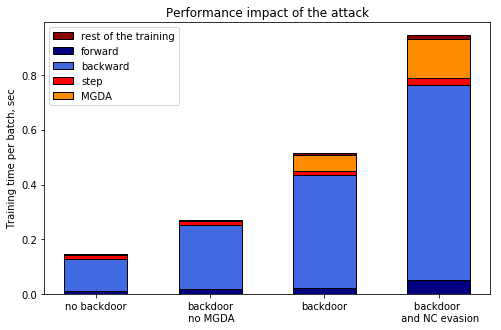

<Figure size 432x288 with 0 Axes>

In [176]:
labels = ['no backdoor', 'backdoor\n no MGDA', 'backdoor', 'backdoor \n and NC evasion']

fw = get_arr('forward')
bw = get_arr('backward')
ps = get_arr('poison')
st = get_arr('step')
sc = get_arr('scales')
tot = get_arr('total')


width = 0.55       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(labels, tot, width,label='rest of the training', linewidth=1, color='darkred', edgecolor='black')
ax.bar(labels, fw, width, label='forward', hatch = '', color='navy', linewidth=1, edgecolor='black')
ax.bar(labels, bw, width, bottom=fw, label='backward', hatch = '', color='royalblue', linewidth=1, edgecolor='black')
ax.bar(labels, st, width, bottom=fw+bw,label='step', color='red', hatch = '', linewidth=1, edgecolor='black')
# ax.bar(labels, ps, width, bottom=fw+bw+st,label='synthesize', color='orange', linewidth=1, edgecolor='black')
ax.bar(labels, sc, width, bottom=st+fw+bw,label='MGDA', color='darkorange', hatch = '', linewidth=1, edgecolor='black')
# ax.bar(labels, women_means, width, yerr=women_std, bottom=men_means,
#        label='Women')

ax.set_ylabel('Training time per batch, sec')
ax.set_title('Performance impact of the attack')
ax.legend()


plt.show()

plt.savefig('performance.pdf')

In [36]:
my_back['backward']

[0.10926508903503418,
 0.12094855308532715,
 0.1856396198272705,
 0.11582589149475098,
 0.11256933212280273,
 0.18071413040161133,
 0.11428666114807129,
 0.1131744384765625,
 0.182481050491333,
 0.1151270866394043,
 0.10460591316223145,
 0.18236899375915527,
 0.11446118354797363,
 0.11066150665283203,
 0.18244600296020508,
 0.11457562446594238,
 0.11016225814819336,
 0.18270182609558105,
 0.11370491981506348,
 0.10623717308044434,
 0.1845109462738037,
 0.11410832405090332,
 0.10641694068908691,
 0.18314361572265625,
 0.11405396461486816,
 0.10742568969726562,
 0.18219733238220215,
 0.11523199081420898,
 0.11015748977661133,
 0.18471002578735352,
 0.11539077758789062,
 0.10460305213928223,
 0.18320775032043457,
 0.11021280288696289,
 0.11118793487548828,
 0.183671236038208,
 0.11423707008361816,
 0.10842418670654297,
 0.1825733184814453,
 0.11543631553649902,
 0.11110329627990723,
 0.18292832374572754,
 0.11607122421264648,
 0.10833287239074707,
 0.18206524848937988,
 0.1165258884429931